In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from pathlib import Path
import tarfile
import urllib.request

In [16]:
# $ virtualenv -v env-data-science
# $ source env-data-science/bin/activate.fish
# $ pip install --upgrade pip
# $ pip3 install ipykernel pandas geopandas matplotlib pathlib 

In [17]:
# Pobranie danych o wynagrodzeniach
# źródło Bank Danych Lokalnych, https://bdl.stat.gov.pl/
# Przeciętne miesięczne wynagrodzenie brutto w sektorze:
# działalność profesjonalna, naukowa i techniczna

def load_salary_data():
    tarball_path = Path("datasets/001.wynagrodzenia-2024-stat-gov.pl.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/brzytwa/datasets/raw/main/001.wynagrodzenia-2024-stat-gov.pl.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as salary_tarball:
        salary_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/WYNA_2687_CTAB_20240510083932.csv"))

load_salary_data()
csv_path = Path("datasets/WYNA_2687_CTAB_20240510083932.csv")
salary = pd.read_csv(csv_path, delimiter=';')

In [18]:
# Przygotowanie danych o wynagrodzeniach
# usunięcie niepotrzebnych kolumn, zmiana nazw kolumn itp.

salary = salary.rename(columns={salary.columns[1]:'nazwa'})
salary = salary.rename(columns={salary.columns[2]:'kwota'})
salary['nazwa'] = salary['nazwa'].str.lower()
salary['kwota'] = salary['kwota'].str.replace(',', '.').astype(float)
salary.drop(salary.columns[0],axis=1,inplace=True)
salary.drop(salary.columns[2],axis=1,inplace=True)

In [19]:
# Pobieranie danych geograficznych o granicach województw
def load_shape_data():
    tarball_path = Path("datasets/001.A01_Granice_wojewodztw.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/brzytwa/datasets/raw/main/001.A01_Granice_wojewodztw.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as shape_tarball:
        shape_tarball.extractall(path="datasets")
    return gpd.read_file(Path("datasets/A01_Granice_wojewodztw.geojson"))

shape = load_shape_data()

In [20]:
# Przygotowanie danych geograficznych

# Projekcja do (układu współrzędnych) EPSG 2180
projected_shape = shape.to_crs(epsg=2180)

# Łączenie danych geograficznych z danymi o wynagrodzeniach
projected_shape['nazwa'] = projected_shape['JPT_NAZWA_'].str.lower()
geo_wynagrodzenia = projected_shape.merge(salary, on = 'nazwa')

<Figure size 9600x6400 with 0 Axes>

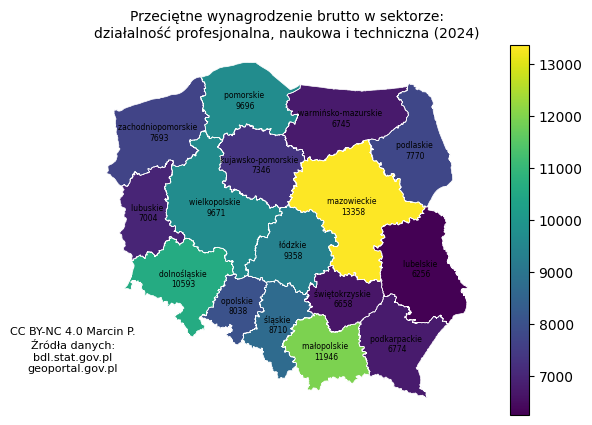

In [21]:
rcParams['font.family'] = 'DejaVu Sans'

plt.figure(dpi = 400, figsize = (24, 16))
ax = geo_wynagrodzenia.boundary.plot(edgecolor = 'white', linewidth = 0.5)

geo_wynagrodzenia.plot(
    ax = ax,
    column = 'kwota',
    cmap = 'viridis',
    legend = True
)

title = "Przeciętne wynagrodzenie brutto w sektorze:\n" + \
    "działalność profesjonalna, naukowa i techniczna (2024)"

plt.title(
    title,
    fontsize = 12,
    fontproperties = FontProperties(family = 'DejaVu Sans')
)

# Ukrywanie osi i innych elementów wykresu
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top', 'left']:
    ax.spines[edge].set_visible(False)

# Dodawanie etykiet z nazwą województwa i wynagrodzeniem
geo_wynagrodzenia['centroid'] = geo_wynagrodzenia.geometry.centroid
for idx, row in geo_wynagrodzenia.iterrows():
    # Użyj formatu .0f, aby wyświetlić kwotę jako liczbę całkowitą
    text = f"{row['JPT_NAZWA_']} \n{int(row['kwota'])}"
    ax.annotate(
        text = text,  
        xy = (row['centroid'].x, row['centroid'].y),  
        horizontalalignment = 'center',
        verticalalignment = 'center',  
        fontsize = 5.5,
        fontproperties = FontProperties(family='DejaVu Sans'),
        color = 'black'
    )

annotation = "CC BY-NC 4.0 Marcin P.\n" + \
    "Źródła danych:\n" + \
    "bdl.stat.gov.pl\n" + \
    "geoportal.gov.pl"

plt.figtext(
    0.1,
    0.2,
    annotation,
    ha = 'center',
    fontsize = 8,
    fontproperties = FontProperties(family='DejaVu Sans')
)

plt.show()